In this notebook, we construct the US Tresury Yield curve from the data provided by the US Dept. of Treasury. 
Please refer to the link below:
https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202405

UST provide par yields (also called CMT rates) in their data set. This makes the bootstrapping a bit tricky since we will have to construct hypothetical bonds and then use QuantLib's classes to construct the yield curve.

References:
1. UST Dept of Treasury website (https://home.treasury.gov/)
2. QuantLib Documentation & Cookbook
3. FAQs: 
   https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/interest-rates-frequently-asked-questions

In [10]:
import QuantLib as ql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import xml.etree.ElementTree as ET
from datetime import datetime

In [32]:
class USTsyYieldCurve:
    def __init__(self, date: ql.Date) -> None:
        self.as_of_date = date
        ql.Settings.instance().evaluationDate = self.as_of_date
        self.api_str = f"{self.as_of_date.year()}{self.as_of_date.month():02d}"
        self.api_url = f"https://home.treasury.gov/resource-center/data-chart-center/interest-rates/pages/xml?data=daily_treasury_yield_curve&field_tdr_date_value_month={self.api_str}"
        self.raw_data = {}
        self.par_yields = self.get_raw_xml_data()
        if len(self.raw_data) > 2 :
            print("Fetched raw data from USDT website!")
        else:
            raise Exception("Error fetching data from USDT website!")

        # Conventions
        self.calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        self.business_convention = ql.ModifiedFollowing
        # See FAQs for Day Counts
        self.day_count = ql.ActualActual(ql.ActualActual.ISDA)
        self.settlement_days = 1
        self.face_amount = 100
        self.coupon_frequency = ql.Period(ql.Semiannual)
        self.end_of_month = False

        # Calibrate the yield curve
        self.calibrate()
        
    def get_discount_factor(self, date: ql.Date):
        return self.yield_curve.discount(date)

    def get_raw_xml_data(self):
        response = requests.get(self.api_url)

        if response.status_code == 200:

            # Parse the XML content
            root = ET.fromstring(response.content)

            # Define namespaces
            namespaces = {
                'atom': 'http://www.w3.org/2005/Atom',
                'm': 'http://schemas.microsoft.com/ado/2007/08/dataservices/metadata',
                'd': 'http://schemas.microsoft.com/ado/2007/08/dataservices'
            }

            # Find all entry tags
            entries = root.findall('.//atom:entry', namespaces)

            # Iterate through each entry tag
            for entry in entries:
                # Find the properties inside content inside entry tags
                content = entry.find('atom:content', namespaces)
                properties = content.find('m:properties', namespaces)
                if properties is not None:
                    # Iterate through each property
                    # Extract the NEW_DATE property and convert it to a datetime object
                    new_date_str = properties.find('d:NEW_DATE', namespaces).text
                    new_date = datetime.strptime(new_date_str, "%Y-%m-%dT%H:%M:%S")

                    if ql.Date(new_date.day, new_date.month, new_date.year) == self.as_of_date:
                        for prop in properties:
                            if (prop.tag.startswith('{http://schemas.microsoft.com/ado/2007/08/dataservices}BC_') 
                            and prop.tag != '{http://schemas.microsoft.com/ado/2007/08/dataservices}BC_30YEARDISPLAY'):
                                tag = prop.tag.split('}')[1]  # Remove namespace from the tag
                                period_str = tag.split("BC_")[1].replace("MONTH","M").replace("YEAR","Y")
                                ql_period = ql.Period(period_str)
                                raw_yield = float(prop.text)
                                self.raw_data.update({ql_period:raw_yield})                

        else:
            print("Failed to fetch XML data. Status code:", response.status_code)

    def get_spot_rates(self, months=360):
        spots = []
        tenors = []
        ref_date = self.as_of_date + self.settlement_days
        calc_date = ref_date
        for month in range(0, months):
            yrs = month / 12.0
            d = self.calendar.advance(ref_date, ql.Period(month, ql.Months))
            compounding = ql.Compounded
            freq = ql.Semiannual
            zero_rate = self.yield_curve.zeroRate(yrs, compounding, freq)
            tenors.append(yrs)
            eq_rate = zero_rate.equivalentRate(
                self.day_count, compounding, freq, calc_date, d
            ).rate()
            spots.append(100 * eq_rate)
        return pd.DataFrame(
            list(zip(tenors, spots)),
            columns=["Maturities", "Zero Rates(%)"],
            index=[""] * len(tenors),
        )

    def calibrate(self):
        bond_helpers = []

        """ 
        Note from USDT website:
        All yields on the par yield curve are on a bond-equivalent basis.
        Therefore, the yields at any point on the par yield curve are consistent with a semiannual coupon security
        with that amount of time remaining to maturity
        """
        for tenor, par_yield in self.raw_data.items():
            maturity_date = self.as_of_date + tenor
            schedule = ql.Schedule(
                self.as_of_date,
                maturity_date,
                self.coupon_frequency,
                self.calendar,
                self.business_convention,
                self.business_convention,
                ql.DateGeneration.Backward,
                self.end_of_month,
            )
            bond_helper = ql.FixedRateBondHelper(
                ql.QuoteHandle(ql.SimpleQuote(self.face_amount)),
                self.settlement_days,
                self.face_amount,
                schedule,
                [par_yield / 100.0],
                self.day_count,
                self.business_convention,
            )
            bond_helpers.append(bond_helper)
        print("Created bond helpers for all tenors!")

        # There is evidence that Monotone Convex Interpolation (which USDT uses for construction of their par curve) is equivalent to
        # Cubic Spline interpolation on log of Discount Factors
        # Reference: arxiv.org/pdf/2005.13890

        self.yield_curve = ql.PiecewiseNaturalLogCubicDiscount(
            self.as_of_date, bond_helpers, self.day_count
        )
        self.yield_curve.enableExtrapolation()
        print("Successfuly calibrated the yield curve!")

Fetched raw data from USDT website!
Created bond helpers for all tenors!
Successfuly calibrated the yield curve!


AttributeError: 'USTsyYieldCurve' object has no attribute 'get_discount_factor'

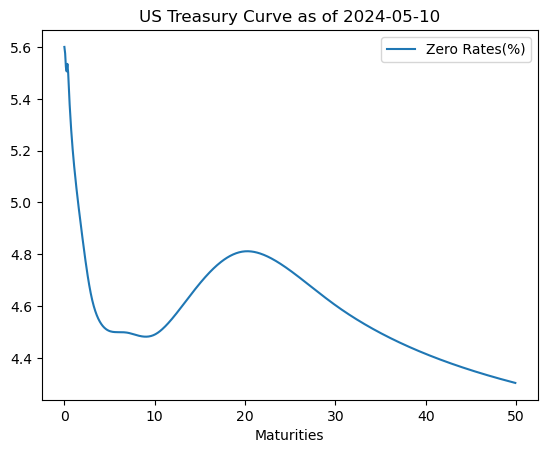

In [35]:
# Fetch data and build the yield curve
as_of_date = ql.Date(10, 5, 2024)
us_yield_curve = USTsyYieldCurve(date=as_of_date)
spot_rates = us_yield_curve.get_spot_rates(months=600)
spot_rates.plot(x="Maturities", y="Zero Rates(%)", title=f"US Treasury Curve as of {as_of_date.ISO()}")
print(us_yield_curve.get_discount_factor(date=ql.Date(10, 5, 2030)))


